# 🔥Song Popularity Prediction 
## This Notebook is purely the implementation of the autoxgb written by [Abhishek](https://www.kaggle.com/abhishek)
### I have done a simple EDA and trained using Autoxgb, loaded the model and created the submission file.
### Note- No FE was done and it's a single model.
### Huge thanks to [Abhishek](https://www.kaggle.com/abhishek) for creating the competition, optuna hp tune notebook out soon along with 14model baseline.

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import datatable as dt



In [2]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
%%time
train = dt.fread('../input/song-popularity-prediction/train.csv').to_pandas().drop('id', axis=1)
train = reduce_memory_usage(train)
test = dt.fread('../input/song-popularity-prediction/test.csv').to_pandas().drop('id', axis=1)
test = reduce_memory_usage(test)
ss = dt.fread('../input/song-popularity-prediction/sample_submission.csv').to_pandas()
ss = reduce_memory_usage(ss)

Mem. usage decreased to 1.03 Mb (71.3% reduction)
Mem. usage decreased to 0.25 Mb (72.0% reduction)
Mem. usage decreased to 0.03 Mb (39.9% reduction)
CPU times: user 160 ms, sys: 15.9 ms, total: 175 ms
Wall time: 384 ms


In [4]:
print(train.shape)
print(test.shape)

(40000, 14)
(10000, 13)


In [5]:
display(train.isna().sum().sum())
display(test.isna().sum().sum())

32187

7962

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
song_duration_ms,35899.0,1.931670e+05,45822.148438,25658.000000,166254.500000,186660.000000,215116.000000,491671.000000
acousticness,36008.0,2.766113e-01,0.297852,-0.013550,0.039612,0.140503,0.482422,1.065430
danceability,35974.0,5.708008e-01,0.189941,0.043976,0.424805,0.608398,0.718262,0.957031
energy,36025.0,6.845703e-01,0.212646,-0.001682,0.539062,0.704590,0.870605,1.040039
instrumentalness,36015.0,3.652954e-02,0.150024,-0.004398,0.000941,0.001974,0.003225,1.075195
key,35935.0,inf,3.373047,0.000000,2.000000,5.000000,8.000000,11.000000
liveness,35914.0,1.986084e-01,0.151611,0.027847,0.111816,0.135986,0.212891,1.065430
loudness,36043.0,-inf,3.878906,-32.125000,-9.578125,-6.343750,-4.621094,-0.877441
speechiness,40000.0,9.411621e-02,0.083618,0.015068,0.038506,0.055878,0.118835,0.560547
tempo,40000.0,inf,26.156250,62.062500,97.000000,113.812500,128.500000,219.125000


In [7]:
train.head(10)

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,212990.0,0.642090,0.856445,0.707031,0.002001,10.0,NaN,-5.617188,False,0.082581,158.3750,4,0.734863,False
1,NaN,0.054871,0.733398,0.835449,0.000996,8.0,0.436523,-5.238281,True,0.127319,102.7500,3,0.711426,True
2,193213.0,NaN,0.188354,0.783691,-0.002693,5.0,0.170532,-4.953125,False,0.052277,178.6250,3,0.425537,False
3,249893.0,0.488770,0.585449,0.552734,0.000608,0.0,0.094788,-7.894531,False,0.035614,128.7500,3,0.453613,False
4,165969.0,0.492920,NaN,0.741211,0.002033,10.0,0.094910,-2.683594,False,0.050751,121.9375,4,0.741211,False
5,188891.0,0.035645,0.825684,0.804688,-0.000005,4.0,0.120728,-6.121094,False,0.039001,115.6875,4,0.709473,False
6,161061.0,0.081726,0.673828,0.880371,0.000327,0.0,0.535645,-2.910156,True,0.030899,98.0625,4,0.982910,False
7,196202.0,0.259766,0.812988,0.554199,0.000390,8.0,0.276611,-7.792969,False,0.207031,158.6250,3,0.663086,True
8,169660.0,NaN,0.653320,0.916992,0.001748,0.0,NaN,-4.421875,False,0.031616,122.3750,3,0.297607,True
9,167245.0,0.019623,0.595215,0.819824,0.761719,5.0,0.181152,-5.152344,False,0.054504,110.5000,4,0.535645,False


Text(0.5, 1.05, 'Target  distribution')

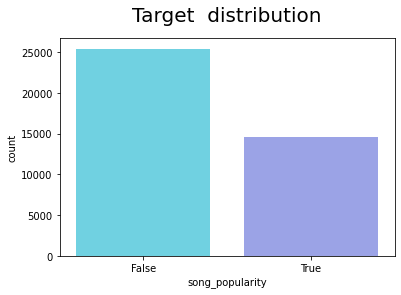

In [8]:
#Lets find traget variable distribution
target_varibale=train['song_popularity']
pal = ['#5ddef4','#8e99f3']
plt=sns.countplot(x=train.song_popularity,palette=pal)
plt.set_title('Target  distribution', fontsize=20, y=1.05)

In [9]:
categorical_features=[]
numerical_features=[]
for i in train.columns:
    if train[i].dtype=='float16':
#         print('yes')
        numerical_features.append(i)
    elif i!='target':
        categorical_features.append(i)
#         print('no')

In [10]:
display(len(categorical_features))
display(len(numerical_features))

4

10

In [11]:
df_num_features = pd.concat([train[numerical_features], train['song_popularity']], axis=1) # still writing even though train and this frame will be same

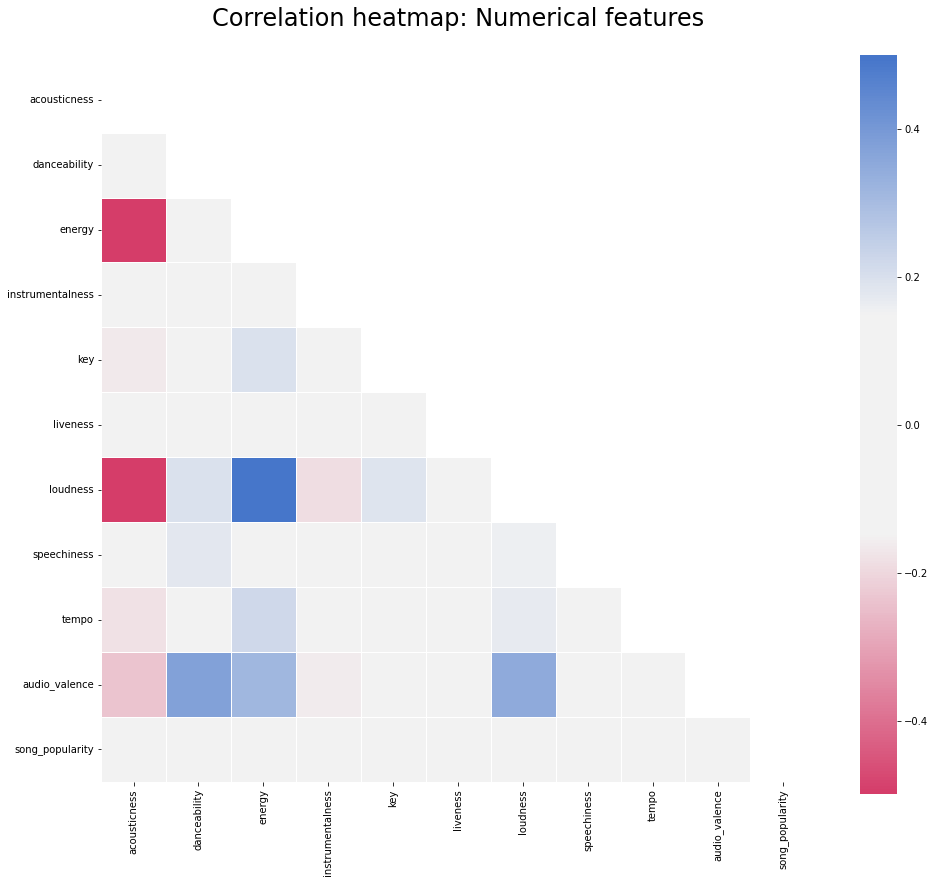

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16 , 16))
corr = df_num_features.sample(10000, random_state=2021).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, ax=ax, square=True, center=0, linewidth=1,
        cmap=sns.diverging_palette(0,255,sep=77, as_cmap=True),vmax=0.5, vmin=-0.5,
        cbar_kws={"shrink": .85}, mask=mask )
ax.set_title('Correlation heatmap: Numerical features', fontsize=24, y= 1.05)
plt.show()

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = train.drop('song_popularity',axis=1)
y = train['song_popularity']
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:805: RuntimeWarning: invalid value encountered in subtract
  X -= self.mean_


In [14]:
!pip install  autoxgb 

     |████████████████████████████████| 15.7 MB 701 kB/s            
     |████████████████████████████████| 173.5 MB 65 kB/s              
     |████████████████████████████████| 57 kB 4.8 MB/s             
     |████████████████████████████████| 23.2 MB 47.7 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.5.1
    Uninstalling xgboost-1.5.1:
      Successfully uninstalled xgboost-1.5.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0

In [15]:
OUTPUT='./'

In [16]:
!autoxgb train \
--train_filename ../input/song-popularity-prediction/train.csv \
--test_filename ../input/song-popularity-prediction/test.csv \
--id IDX \
--target song_popularity \
--task classification \
--num_folds 5 \
--time_limit 3600 \
--output OUTPUT \
--use_gpu

2022-01-18 20:50:27.795 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: OUTPUT
2022-01-18 20:50:27.795 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2022-01-18 20:50:27.910 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 1.18 Mb (74.2% reduction)
2022-01-18 20:50:27.912 | INFO     | autoxgb.autoxgb:_determine_problem_type:140 - Problem type: binary_classification
2022-01-18 20:50:27.947 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.27 Mb (75.0% reduction)
2022-01-18 20:50:27.947 | INFO     | autoxgb.autoxgb:_create_folds:58 - Creating folds
2022-01-18 20:50:27.959 | INFO     | autoxgb.autoxgb:_process_data:170 - Encoding target(s)
2022-01-18 20:50:27.966 | INFO     | autoxgb.autoxgb:_process_data:195 - Found 0 categorical features.
2022-01-18 20:50:28.094 | INFO     | autoxgb.autoxgb:_process_data:236 - Model config: train_filename='../input/song-popularity-prediction/train.csv' test_

In [18]:
pred_df=dt.fread('./OUTPUT/test_predictions.csv').to_pandas()

final_class=[]
for i in pred_df.iterrows():
    current_class=1
    if i[1][1] >i[1][2]:
        current_class=0
        final_class.append(current_class)
    else:
         final_class.append(current_class)
        
    

In [20]:
ss = dt.fread('../input/song-popularity-prediction/sample_submission.csv').to_pandas()
ss['song_popularity'] = final_class
ss.to_csv('sub.csv', index=False)
ss.head()

,id,song_popularity
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
